## 0. Download dataset

In [ ]:
# Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM/view
!gdown 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
!unzip -q icdar2003.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
From (redirected): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM&confirm=t&uuid=82952035-c935-41ac-b6bc-64db67e0e5ff
To: /home/aivn12s1/thangdd/project_scene_text_detection/icdar2003.zip
100%|██████████████████████████████████████| 45.7M/45.7M [00:02<00:00, 19.6MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import libraries

In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.0/78.2 GB disk)


In [2]:
import os
import shutil
import yaml
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in YOLOv8 format

In [3]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall('taggedRectangles'):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib['x']),
                        float(bb.attrib['y']),
                        float(bb.attrib['width']),
                        float(bb.attrib['height'])
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib['x']), int(image[1].attrib['y'])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [5]:
dataset_dir = '/content/drive/MyDrive/SceneTextRecognition/icdar2003/SceneTrialTrain'
words_xml_path = os.path.join(
    dataset_dir,
    'words.xml'
)
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(words_xml_path)

## 3. Convert to YOLOv8 format

In [6]:
def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    yolov8_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolov8_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLOv8 format
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data

In [7]:
# Define class labels
class_labels = ['text']

# Convert data into YOLOv8 format
yolov8_data = convert_to_yolov8_format(
    image_paths,
    image_sizes,
    bounding_boxes
)

In [8]:
yolov8_data[0]

('apanar_06.08.2002/IMG_1261.JPG',
 ['0 0.194375 0.40791666666666665 0.17125 0.1625',
  '0 0.5321875 0.40208333333333335 0.424375 0.1525',
  '0 0.309375 0.5825 0.38875 0.145',
  '0 0.67875 0.5770833333333333 0.27875 0.15583333333333332',
  '0 0.0746875 0.04125 0.059375 0.0725',
  '0 0.2159375 0.03833333333333333 0.123125 0.07333333333333333',
  '0 0.5309375 0.03375 0.071875 0.0675',
  '0 0.19625 0.7645833333333333 0.1425 0.11583333333333333',
  '0 0.3471875 0.7770833333333333 0.103125 0.09083333333333334',
  '0 0.4496875 0.7758333333333334 0.044375 0.08833333333333333',
  '0 0.571875 0.7620833333333333 0.13625 0.1175'])

## 4. Train, val, test split

In [9]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolov8_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## 5. Save data

In [10]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    for image_path, yolov8_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path),
            os.path.join(save_dir, 'images')
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)  # lấy phần cuối cùng của đường dẫn
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f"{label}\n")

In [11]:
save_yolo_data_dir = '/content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(
    save_yolo_data_dir,
    'train'
)
save_val_dir = os.path.join(
    save_yolo_data_dir,
    'val'
)
save_test_dir = os.path.join(
    save_yolo_data_dir,
    'test'
)

save_data(
    train_data,
    dataset_dir,
    save_train_dir
)
save_data(
    test_data,
    dataset_dir,
    save_val_dir
)
save_data(
    val_data,
    dataset_dir,
    save_test_dir
)

## 6. Create yaml file

In [15]:
data_yaml = {
    'path': '/content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False) #ghi dữ liệu từ biến data_yaml vào tệp mà chúng ta đã mở ở bước trước

## 7. Training

In [16]:
!cd /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8s.yaml')  # build a new model from YAML
# model = YOLO('yolov8s.pt')  # load a pretrained model
model = YOLO('yolov8s.yaml').load('yolov8s.pt')  # build from YAML and transfer weights

# Train the model
epochs = 200
imgsz = 1024
results = model.train(
    data=yolo_yaml_path,
    epochs=epochs,
    imgsz=imgsz,
    project='/content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition',
    name='yolov8/detect/train'
)

/bin/bash: line 1: cd: too many arguments

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultraly

100%|██████████| 755k/755k [00:00<00:00, 76.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 281MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 199.70it/s]


train: New cache created: /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolo_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 176.28it/s]

val: New cache created: /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolo_data/val/labels.cache


Plotting labels to /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/train4
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      9.55G      2.106      5.439      1.857         41       1024: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         43        200      0.387       0.57      0.423      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      9.76G      1.117      1.809      1.159         73       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.702        0.7      0.726      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      9.48G      1.143      1.415      1.158         75       1024: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         43        200      0.645      0.781      0.732      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      9.82G      1.124      1.266      1.155        101       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all         43        200      0.411      0.655      0.425      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      9.77G       1.13      1.224      1.171         55       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.775      0.515      0.613      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      9.73G      1.205      1.271      1.204         39       1024: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200      0.366      0.395      0.221      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      9.79G      1.139      1.115      1.152         48       1024: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43        200      0.239       0.17      0.105     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      9.64G      1.257      1.257      1.229         42       1024: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         43        200      0.362      0.595      0.415      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      9.57G      1.189      1.163      1.206         37       1024: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         43        200      0.614      0.255      0.317      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      9.72G      1.211      1.125      1.213         89       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.252      0.455      0.189     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200       9.8G      1.156      1.082      1.187         56       1024: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200       0.69        0.6      0.603      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      9.87G      1.152      1.095      1.175         74       1024: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43        200      0.556      0.595      0.531      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      9.78G      1.102      1.035      1.146         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         43        200       0.59      0.595      0.586      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      9.85G      1.104     0.9345      1.138         59       1024: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         43        200      0.635      0.705      0.686      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      9.85G      1.111     0.9855      1.172         63       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.707       0.75      0.731       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      9.61G      1.163      1.005      1.191         54       1024: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.617      0.491      0.477      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      9.77G      1.153      1.007      1.195         66       1024: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.756      0.803      0.781      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      9.85G      1.079     0.9467      1.158         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         43        200      0.757      0.856      0.844      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      9.78G      1.025     0.8662       1.12         39       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         43        200       0.82      0.805      0.806      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      9.87G      1.128     0.9303      1.151         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         43        200      0.773      0.802      0.761      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      9.83G      1.059     0.8862      1.142         92       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         43        200      0.758      0.876      0.803       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      9.83G      1.086     0.8739      1.116         41       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.773      0.853      0.823      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      9.86G       1.02      0.871      1.133         51       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200        0.8      0.835      0.829      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      9.86G       1.05     0.8663      1.113         91       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         43        200      0.755      0.745      0.801      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      9.77G      1.063     0.8736      1.138        117       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         43        200      0.767      0.805       0.82      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      9.73G      1.015     0.8579      1.117         72       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.839      0.859      0.849      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200       9.6G      0.995     0.8597      1.112         48       1024: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.773       0.82      0.814      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       9.6G     0.9925     0.8437      1.091         60       1024: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.774      0.876      0.841      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      9.76G     0.9431     0.7444      1.085         69       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         43        200      0.854      0.874       0.87      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      9.71G     0.9637     0.7851      1.089         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         43        200      0.845      0.873      0.861      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      9.71G     0.9243      0.821       1.08         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         43        200      0.825      0.865      0.854      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      9.58G     0.9346     0.7705      1.073         88       1024: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         43        200      0.848      0.865       0.87      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      9.71G      0.971     0.7802      1.092         85       1024: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         43        200      0.837       0.91      0.894      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      9.72G     0.9505      0.731      1.062         54       1024: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         43        200      0.844       0.82      0.845      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      9.83G      0.957     0.7895      1.089         29       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all         43        200      0.886      0.835      0.881      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200       9.8G     0.9648     0.7676      1.099         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         43        200      0.837      0.905      0.876      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      9.71G     0.9219     0.7507      1.057         43       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         43        200      0.798      0.875      0.824      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      9.85G      0.926     0.7624      1.065         63       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.812       0.85      0.841      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      9.52G     0.9568     0.7869      1.058         37       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         43        200      0.715      0.853      0.839      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      9.82G     0.9207     0.7601      1.049         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         43        200      0.811      0.905       0.86      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      9.79G     0.9214     0.7352      1.064         55       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         43        200      0.823      0.816      0.845      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       9.8G     0.8885     0.7142      1.051         35       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         43        200      0.808      0.905       0.86      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      9.83G     0.9305     0.7328      1.066         38       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.811        0.9      0.873      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      9.59G     0.9439     0.7112      1.056         51       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         43        200      0.833      0.872       0.87      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      9.51G     0.9162     0.6907      1.038         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         43        200      0.883      0.865      0.892      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      9.79G     0.8513     0.6684      1.012         55       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.836      0.885      0.899      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200       9.8G      0.892     0.7051      1.052         78       1024: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         43        200      0.878      0.898      0.891      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      9.57G     0.8611     0.6802      1.028         32       1024: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.816      0.934       0.88      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      9.43G     0.8453      0.664       1.02         59       1024: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         43        200       0.84      0.895      0.886      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      9.78G     0.8501     0.6487      1.037         63       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         43        200      0.856      0.894      0.884       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      9.62G     0.8365      0.657      1.027         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.821       0.87      0.858      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      9.82G     0.8775     0.6406      1.043         88       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         43        200      0.917      0.824      0.895      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      9.59G     0.8468     0.6444      1.016        124       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.879      0.855       0.89      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       9.8G     0.8551      0.645      1.026         64       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         43        200      0.818      0.855      0.874      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      9.67G      0.838     0.6372      1.032         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.839      0.883      0.905       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       9.6G     0.8578     0.6433      1.011        101       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.881       0.86      0.916      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      9.72G     0.8755     0.6587      1.027         34       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.886      0.893      0.907       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      9.73G     0.8542     0.6442      1.035         50       1024: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         43        200      0.863      0.914      0.891      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       9.6G     0.7899     0.5933     0.9823         60       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         43        200      0.852      0.893      0.901      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      9.78G     0.8691     0.6265      1.023         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         43        200      0.845       0.89      0.907      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      9.82G     0.8461     0.6318       1.01         94       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.874      0.905      0.894      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      9.59G     0.8161     0.6154      1.016         61       1024: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.837       0.87      0.881      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      9.61G      0.822     0.6108     0.9995         71       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         43        200      0.827       0.89      0.887      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      9.61G     0.8202     0.6095      1.025         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         43        200      0.851      0.895      0.893      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      9.76G     0.7827     0.5819     0.9932         60       1024: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.864      0.885      0.889      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      9.77G     0.8022     0.5911      1.001         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.851       0.89      0.892      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200       9.8G     0.8015     0.6016      1.018         51       1024: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.849      0.896        0.9      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      9.61G     0.8142     0.5995      1.019         54       1024: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         43        200      0.857      0.845       0.87      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      9.58G     0.8182     0.6066     0.9931         54       1024: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         43        200       0.87      0.868      0.908       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      9.79G     0.8073     0.6193      1.007         35       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         43        200      0.916       0.82      0.915      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      9.86G     0.7519     0.5623      0.975         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.899       0.86      0.916      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      9.45G     0.7847     0.5947      1.001         34       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43        200      0.907       0.86      0.894      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      9.77G     0.8202     0.5686     0.9922         53       1024: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.911       0.87      0.897      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      9.81G     0.8109     0.5838     0.9889         62       1024: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.908      0.886      0.911      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      9.47G     0.7885      0.574     0.9905         17       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         43        200      0.859       0.88      0.891      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      9.79G      0.799     0.5818     0.9901         78       1024: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         43        200      0.872      0.923      0.912       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      9.76G     0.7758     0.5685      1.001         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200        0.9      0.898       0.92       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      9.78G     0.7659     0.5775     0.9843         52       1024: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         43        200      0.863      0.935      0.921      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      9.62G     0.7796     0.5726     0.9769         67       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         43        200       0.87      0.903      0.909      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      9.46G     0.7864     0.5668      0.992         52       1024: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.844       0.91      0.905      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      9.77G     0.7128     0.5286     0.9667         48       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]

                   all         43        200      0.832       0.92      0.911      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      9.71G     0.7323     0.5308     0.9659         64       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         43        200      0.872      0.905      0.911       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      9.83G     0.7612     0.5594     0.9929         53       1024: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         43        200      0.885      0.889      0.906        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      9.58G     0.7637     0.5667     0.9784         61       1024: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.883      0.885      0.922      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      9.78G     0.7698     0.5801      1.004         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         43        200      0.838      0.931       0.93      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      9.83G     0.7681     0.5406     0.9701         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         43        200      0.902      0.871      0.933      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       9.8G     0.7459      0.543     0.9661         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         43        200      0.917      0.875      0.933      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200       9.8G      0.743     0.5345     0.9945         85       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         43        200      0.903       0.91      0.936      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      9.69G     0.7708     0.5636      1.012         63       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.888      0.915      0.933      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      9.64G     0.7403     0.5421     0.9736         67       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.879      0.915      0.923      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      9.76G     0.7445     0.5349     0.9758         33       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         43        200      0.887      0.906      0.921      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      9.52G     0.7239     0.5231     0.9601         75       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.883      0.907       0.92      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      9.69G     0.7329     0.5115     0.9595         55       1024: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.898      0.875      0.901      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      9.81G     0.6991     0.4994     0.9607         65       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.899      0.895      0.909      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      9.61G     0.7222     0.5196     0.9667         61       1024: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200      0.883      0.869      0.894       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      9.61G     0.7406      0.523     0.9551         85       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         43        200      0.864      0.888       0.91      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      9.77G     0.6971      0.492     0.9479         55       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         43        200      0.806       0.92      0.909      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      9.78G     0.6629     0.4733     0.9479         53       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         43        200      0.832       0.93      0.916      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      9.72G     0.6898     0.4906     0.9587         56       1024: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.859      0.865      0.905      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      9.79G     0.7132     0.5031     0.9482         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         43        200      0.857      0.865       0.89      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      9.81G     0.7099     0.5058      0.948         39       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         43        200      0.906      0.869      0.917      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      9.82G     0.7369     0.5033     0.9822         59       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.883      0.905      0.911      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       9.5G     0.7105     0.4936      0.946         74       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200       0.89      0.895       0.92      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200       9.8G     0.6909     0.4821     0.9462         59       1024: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.859      0.944      0.922      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      9.58G     0.6851     0.4717     0.9395         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         43        200      0.905       0.89      0.926      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      9.72G     0.6854     0.4837     0.9516         68       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         43        200      0.893        0.9      0.917      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200       9.8G     0.6694     0.4693     0.9351         78       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         43        200      0.866      0.875      0.906      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      9.81G     0.6789     0.4739     0.9468         51       1024: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         43        200      0.899      0.875      0.913      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      9.63G     0.6643     0.4657     0.9304         50       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         43        200      0.888       0.87      0.906      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      9.79G     0.6776     0.4787     0.9619         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

                   all         43        200      0.894      0.895       0.91      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      9.78G     0.6758     0.4632     0.9515         38       1024: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200      0.911      0.871      0.925      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      9.83G     0.6867     0.4687     0.9411         50       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         43        200       0.88      0.882      0.921      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      9.41G     0.7036     0.4736      0.965         29       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         43        200      0.897      0.885      0.921      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      9.59G     0.6885     0.4911     0.9487        115       1024: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.867      0.914      0.911      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      9.61G     0.6827     0.4712     0.9407         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         43        200      0.861      0.929      0.923      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      9.63G     0.7036     0.4714     0.9399         95       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.842      0.929      0.928      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      9.82G     0.6628     0.4665     0.9488         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.856       0.92      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      9.43G     0.6534     0.4614     0.9401         67       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.887      0.901      0.921       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      9.45G      0.652     0.4446     0.9223         49       1024: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         43        200      0.877        0.9      0.928      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      9.79G     0.6765     0.4612     0.9434         51       1024: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.883       0.93      0.923      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200       9.6G      0.643      0.447     0.9218         61       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         43        200      0.882      0.925      0.918      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      9.78G     0.6624     0.4391     0.9315         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         43        200      0.893      0.919      0.911      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      9.49G     0.6588     0.4459      0.936         42       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         43        200      0.891      0.938      0.914      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200       9.8G     0.6623     0.4645     0.9359         29       1024: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         43        200      0.875       0.94      0.922      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      9.83G     0.6368     0.4351     0.9251         44       1024: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.923       0.89      0.907      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      9.59G     0.6161     0.4237     0.9271         62       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         43        200       0.91      0.905      0.912      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      9.62G     0.6474     0.4476     0.9346         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         43        200      0.912      0.885      0.918      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      9.85G     0.6531     0.4631     0.9227         41       1024: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         43        200      0.865       0.93      0.927      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200       9.8G     0.6212     0.4511     0.9245         48       1024: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.855      0.945      0.929      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      9.49G     0.6214      0.445     0.9206         67       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.906      0.872      0.924      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200       9.8G     0.6401     0.4395     0.9332         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         43        200      0.899       0.88       0.92      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      9.62G     0.6215     0.4264     0.9081         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         43        200      0.893       0.91      0.925      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      9.56G     0.6147       0.43     0.9144         92       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200      0.867      0.916       0.92      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      9.81G     0.6161     0.4289     0.9212        101       1024: 100%|██████████| 13/13 [00:10<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.871      0.908      0.917      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      9.85G     0.6268      0.417     0.9289         63       1024: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.902      0.905      0.936      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      9.44G     0.6279     0.4349     0.9145         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all         43        200      0.908        0.9      0.929      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      9.41G     0.6187     0.4366     0.9212         89       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200       0.91      0.885      0.923      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200       9.8G     0.5999     0.4248     0.9194         77       1024: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200       0.88      0.914      0.923      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      9.88G     0.5927     0.4086     0.9236         32       1024: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.909      0.895      0.929      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      9.62G     0.5768     0.3985     0.9034         66       1024: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.921        0.9       0.94      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      9.63G      0.605      0.411     0.9285         76       1024: 100%|██████████| 13/13 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         43        200      0.885      0.923      0.938      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      9.78G     0.5972     0.4115     0.9187         47       1024: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         43        200      0.906      0.913      0.926       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200       9.8G     0.6063     0.3952     0.9134         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.908      0.925      0.923      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      9.62G     0.5891     0.3972     0.9053         31       1024: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.919      0.906      0.917      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      9.75G     0.5801     0.4054     0.9176         46       1024: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         43        200      0.902      0.918      0.924      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      9.79G     0.5675     0.3926     0.8938         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         43        200      0.925      0.885      0.924      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      9.64G     0.5731     0.3839     0.9157         68       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.902       0.89       0.92      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      9.65G     0.6135     0.4105     0.9058         50       1024: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.902      0.877      0.923      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      9.56G      0.585     0.3876     0.9104         44       1024: 100%|██████████| 13/13 [00:10<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200      0.913       0.88      0.922      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      9.79G     0.5466     0.3716     0.9079         74       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.921       0.87      0.924      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200       9.6G      0.578     0.3876     0.8974        102       1024: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all         43        200      0.898       0.91      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      9.79G     0.5703     0.3853      0.911         35       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         43        200      0.884      0.915      0.933      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      9.59G     0.5731     0.3825     0.9037         84       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.894      0.885      0.937      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      9.79G     0.5581     0.3751     0.8961         68       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         43        200      0.918      0.895      0.937       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      9.62G     0.5736     0.3777     0.9123         91       1024: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         43        200      0.913       0.89       0.94      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      9.87G      0.562     0.3863     0.9136         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         43        200      0.922      0.895      0.949      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200       9.6G     0.5458     0.3759     0.8979         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.927      0.884      0.945      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      9.84G      0.557     0.3822     0.8988         56       1024: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         43        200      0.935       0.88      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      9.83G     0.5496     0.3768     0.9041         81       1024: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.903      0.875      0.928      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      9.61G     0.5646     0.3869     0.9029         41       1024: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         43        200      0.888       0.89       0.92      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      9.59G     0.5536     0.3848     0.9012         45       1024: 100%|██████████| 13/13 [00:10<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         43        200      0.899      0.886      0.923      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      9.81G     0.5577     0.3844     0.9011         63       1024: 100%|██████████| 13/13 [00:10<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.867       0.91      0.927      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      9.65G     0.5419      0.373     0.8964         66       1024: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         43        200      0.916       0.88      0.935      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      9.62G     0.5582     0.3826     0.8922         87       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         43        200      0.927      0.845      0.934      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      9.78G     0.5512     0.3804     0.9099         41       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.854       0.91       0.94      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      9.81G     0.5702     0.3822     0.9112         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         43        200      0.845       0.92      0.939       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      9.61G     0.5592     0.3727     0.9033         30       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         43        200      0.852       0.92      0.929      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      9.77G     0.5133     0.3495     0.8899         79       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.865        0.9      0.929       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200       9.8G     0.5187     0.3518     0.8905         43       1024: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.882      0.905      0.932      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      9.79G     0.5185      0.348     0.8936        102       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         43        200      0.879       0.91      0.929      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       9.8G     0.5342     0.3665     0.9002         57       1024: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.861       0.93      0.928      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      9.84G     0.5024     0.3541     0.8812         49       1024: 100%|██████████| 13/13 [00:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         43        200      0.886      0.898      0.935       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200       9.6G     0.5178     0.3579     0.8981         51       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.899      0.895      0.936      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      9.85G     0.5253     0.3612     0.8935         38       1024: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         43        200      0.922       0.87      0.931      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      9.84G     0.5072     0.3517     0.8767         18       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         43        200       0.92       0.86      0.925      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200       9.6G     0.5109     0.3638     0.8928         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all         43        200      0.918       0.88      0.934      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200       9.6G     0.5333     0.3481     0.9166        113       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         43        200      0.914       0.89      0.935       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      9.49G      0.506     0.3491     0.8824         59       1024: 100%|██████████| 13/13 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.893       0.89      0.931      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      9.86G     0.5246     0.3581      0.894         40       1024: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.882      0.896       0.93      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      9.79G     0.5087     0.3465     0.8859         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         43        200      0.888      0.865      0.929      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200       9.7G     0.4985     0.3454      0.877         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         43        200      0.865      0.905      0.932      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      9.61G     0.4849     0.3378     0.8824         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         43        200      0.907       0.88      0.931      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      9.73G     0.5161     0.3524     0.8921         66       1024: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         43        200      0.921      0.869      0.933      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      9.81G     0.5052     0.3355      0.876         56       1024: 100%|██████████| 13/13 [00:10<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         43        200      0.916       0.88      0.934      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      9.77G     0.5227      0.355      0.884         58       1024: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         43        200      0.908      0.892       0.93      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      9.78G     0.5105     0.3494     0.8814         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         43        200      0.907      0.895      0.931      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      9.81G     0.4965     0.3352     0.8809         69       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.893        0.9      0.932      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200       9.8G     0.5025     0.3393     0.8797         52       1024: 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.894       0.89      0.932      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      9.82G     0.4899      0.335     0.8862         47       1024: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.892      0.895      0.933      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200       9.8G     0.4831     0.3344     0.8753         40       1024: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all         43        200       0.88      0.905      0.935      0.744


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      9.78G     0.4654     0.3291     0.8496         26       1024: 100%|██████████| 13/13 [00:13<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200      0.876      0.919      0.933      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      9.59G     0.4874     0.3264     0.8616         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         43        200      0.864      0.915      0.931      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      9.65G     0.4694     0.3191     0.8651         20       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.897       0.88      0.929      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      9.78G     0.4587     0.3256     0.8453         16       1024: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         43        200      0.884      0.881      0.927      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      9.79G     0.4417     0.3142     0.8452         19       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.916      0.855      0.928      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200       9.8G     0.4439     0.3074     0.8442         68       1024: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         43        200      0.894      0.887      0.926      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      9.76G     0.4357     0.3098     0.8451         19       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.899      0.889      0.928      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      9.81G     0.4521     0.3101       0.85         34       1024: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         43        200      0.891        0.9      0.928      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      9.73G     0.4423     0.3065     0.8388         21       1024: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         43        200      0.898        0.9      0.927      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      9.79G     0.4768     0.3358      0.866         43       1024: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         43        200      0.892      0.895      0.926      0.726



200 epochs completed in 0.746 hours.
Optimizer stripped from /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/train4/weights/last.pt, 22.6MB
Optimizer stripped from /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/train4/weights/best.pt, 22.6MB

Validating /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/train4/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


                   all         43        200        0.9      0.896      0.936      0.756
Speed: 0.4ms preprocess, 9.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/train4


## 8. Evaluation

In [18]:
from ultralytics import YOLO

model_path = '/content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/train4/weights/best.pt'
model = YOLO(model_path)

metrics = model.val(
    project='/content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition',
    name='yolov8/detect/val'
)

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


                   all         43        200        0.9      0.895      0.936      0.755
Speed: 0.6ms preprocess, 52.5ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/val


## 9. Inference

In [19]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(
    img_path, predictions,
    conf_thres=0.8,
    font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)


    return img

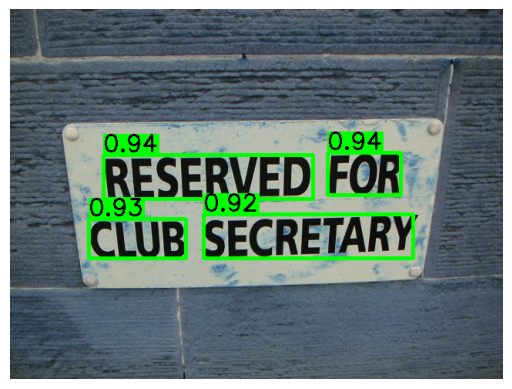

In [20]:
from ultralytics import YOLO

model_path = '/content/drive/MyDrive/SceneTextRecognition/Scene Text Recognition/yolov8/detect/train4/weights/best.pt'
img_path = '/content/drive/MyDrive/SceneTextRecognition/icdar2003/SceneTrialTrain/ryoungt_03.09.2002/PICT0029.JPG'
conf_thres=0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].tojson())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis('off')
plt.show()